In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/MSBD/5001/individual project/

Mounted at /content/drive
/content/drive/My Drive/MSBD/5001/individual project


In [2]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
!pip install --upgrade lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
!pip install catboost
from catboost import CatBoostClassifier, Pool

     |████████████████████████████████| 2.0 MB 7.6 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_result = pd.read_csv('./data/sample_submission.csv')

In [4]:
print('Number of train data:',len(train_df))
print('Number of features:',len(train_df.columns)-1)
label_0 = train_df[train_df['label']==0].iloc[:,1:-1] # exclude the id and label column
label_1 = train_df[train_df['label']==1].iloc[:,1:-1]
print('Number of 0 label:', len(label_0))
print('Number of 1 label:', len(label_1))
print('Columns in train df:\n',train_df.columns)

Number of train data: 87
Number of features: 12
Number of 0 label: 58
Number of 1 label: 29
Columns in train df:
 Index(['id', 'MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)',
       'CD3+T (cells/ul)', 'CD8+T (cells/ul)', 'CD4+T (cells/ul)',
       'NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'Age',
       'Sex 0M1F', 'Mono CD64+MFI (cells/ul)', 'label'],
      dtype='object')


In [5]:
# visualize result
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
# LGBM search hyperparameter
model_lgb = lgb.LGBMClassifier(objective='binary', learning_rate=0.05, max_depth=3,
                              metric='auc', bagging_freq = 5)

params={
    'boosting_type': ['gbdt'],
    #'max_depth': [2, 3, 4, 5, 6],
    'num_leaves': [4],
    'min_child_samples': [16],
    'min_child_weight': [0.00005],
    'feature_fraction': [0.75],
}

gsearch = GridSearchCV(estimator=model_lgb, param_grid=params, scoring='roc_auc', cv=5, verbose=1, n_jobs=1)
gsearch.fit(train_df.iloc[:,1:-1], train_df.iloc[:,-1])
print('Best params:', gsearch.best_params_, 'Best AUC:', gsearch.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[Ligh

In [14]:
# normalize the data
scaler = MinMaxScaler()
scaler.fit(train_df.iloc[:,1:-1])
normalized_train_x = scaler.transform(train_df.iloc[:,1:-1])
fill_nan_normalized_train_x = np.nan_to_num(normalized_train_x)
train_y = train_df.iloc[:,-1]
normalized_test_x = scaler.transform(test_df.iloc[:,1:])
#lgb_train = lgb.Dataset(normalized_x, label=train_df.iloc[:,-1])
# X_train, X_valid, y_train, y_valid = train_test_split(normalized_x, train_df.iloc[:,-1], test_size=0.05)

### LGBM (0.93103)

In [39]:
scoring = ['roc_auc']
clf = lgb.LGBMClassifier(learning_rate=0.05, subsample_freq=5, subsample=0.75)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

In [40]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [41]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result

In [43]:
submission_result.to_csv('./data/sample_submission_lgbm2.csv', index=False)

### naive_bayes (0.82758)

In [ ]:
scoring = ['roc_auc']
clf = GaussianNB()
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)
#bayes_train_y_pred = gnb.fit(fill_nan_normalized_train_x, train_y).predict(fill_nan_normalized_train_x)

In [ ]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [ ]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result.to_csv('./data/sample_submission_bayes.csv', index=False)

### XGBoost (0.96551)

In [47]:
scoring = ['roc_auc']
clf = xgb.XGBClassifier(learning_rate=0.05)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

In [48]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [50]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result

In [52]:
submission_result.to_csv('./data/sample_submission_xgb2.csv', index=False)

### logistic regression (0.96551)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=8).fit(fill_nan_normalized_train_x, train_y)
logit_train_y_pred = clf.predict(fill_nan_normalized_train_x)

              precision    recall  f1-score   support

     class 0       0.95      0.93      0.94        59
     class 1       0.86      0.89      0.88        28

    accuracy                           0.92        87
   macro avg       0.91      0.91      0.91        87
weighted avg       0.92      0.92      0.92        87

Confusion matrix, without normalization
[[55  4]
 [ 3 25]]


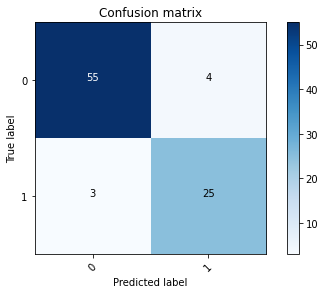

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(logit_train_y_pred, train_y, target_names=target_names))
cm = confusion_matrix(logit_train_y_pred, train_y)
plot_confusion_matrix(cm, [0, 1])

In [ ]:
preds = clf.predict(normalized_test_x)
submission_result['label'] = preds
submission_result.to_csv('./data/sample_submission_logistic.csv', index=False)

### SVM (0.89655)

In [ ]:

from sklearn import svm

scoring = ['roc_auc']
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

"clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))\nclf = clf.fit(normalized_train_x, train_y)\nsvm_train_y_pred = clf.predict(normalized_train_x)"

In [ ]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [ ]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result.to_csv('./data/sample_submission_svm.csv', index=False)

### random forest (0.96551)

In [ ]:
clf = RandomForestClassifier(max_depth=None, random_state=None)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

'clf = clf.fit(normalized_train_x, train_y)\nrf_train_y_pred = clf.predict(normalized_train_x)'

In [ ]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [ ]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result.to_csv('./data/sample_submission_rf.csv', index=False)

### GradientBoostingClassifier (0.89655)

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

In [ ]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [ ]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')

In [ ]:
submission_result.to_csv('./data/sample_submission_gbc.csv', index=False)

### CatBoost (Score: 0.93103)

In [ ]:
from catboost import Pool, cv
cat_features = [9]
cv_dataset = Pool(data=train_df.iloc[:,1:-1],
                  label=train_y, cat_features=cat_features)

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          'eval_metric' : 'AUC',
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(cv_dataset, params, nfold=8, return_models=True, early_stopping_rounds=10)

In [ ]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores[-1]:
  preds += estimator.predict(test_df.iloc[:,1:])/8

In [ ]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')
submission_result.to_csv('./data/sample_submission_catboost.csv', index=False)

### AdaBoost (0.96551)

In [53]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(learning_rate=0.05)
scores = cross_validate(clf, fill_nan_normalized_train_x, train_y, scoring=scoring, cv=8, return_estimator=True)

In [54]:
preds = np.zeros_like(submission_result['label'].values).astype('float64')
for estimator in scores['estimator']:
  preds += estimator.predict(normalized_test_x)/8

In [56]:
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
submission_result['label'] = preds.astype('int')
submission_result.to_csv('./data/sample_submission_adaboost.csv', index=False)

### NN (0.82758)

In [107]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

parameter_space = {
    'hidden_layer_sizes': [(8,16,8), (8,8), (16,8), (32)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [1, 0.1, 0.01]
}

mlp = MLPClassifier(max_iter=2000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=500)
clf = RandomizedSearchCV(mlp, parameter_space, n_jobs=-1, cv=10, verbose=1)
clf.fit(fill_nan_normalized_train_x, train_y)
mlp_train_pred = clf.predict(fill_nan_normalized_train_x)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


              precision    recall  f1-score   support

     class 0       0.95      0.82      0.88        67
     class 1       0.59      0.85      0.69        20

    accuracy                           0.83        87
   macro avg       0.77      0.84      0.79        87
weighted avg       0.87      0.83      0.84        87

Confusion matrix, without normalization
[[55 12]
 [ 3 17]]


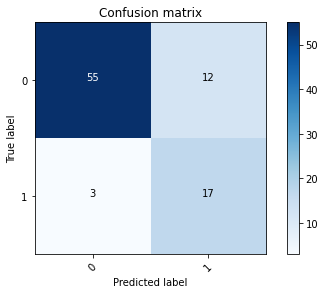

In [108]:
target_names = ['class 0', 'class 1']
print(classification_report(mlp_train_pred, train_y, target_names=target_names))
cm = confusion_matrix(mlp_train_pred, train_y)
plot_confusion_matrix(cm, [0, 1])

In [109]:
mlp_test_pred = clf.predict(normalized_test_x)

In [ ]:
submission_result['label'] = mlp_test_pred
submission_result.to_csv('./data/sample_submission_nn.csv', index=False)

### Tree Model ensemble

Choose 3 best models for voting (private accuracy)

* lgb: 0.93103
* xgboost: 0.96551
* RandomForestClassifier: 0.96551
* GradientBoostingClassifier: 0.89655
* catboost: 0.93103
* Logistic: 0.96551
* SVM: 0.89655
* AdaBoost: 0.96551
* ~~Neural Network: 0.82758~~
* ~~Naive Bayes: 0.82758~~



In [113]:
lgb_submission = pd.read_csv('./data/sample_submission_lgbm.csv')
xgb_submission = pd.read_csv('./data/sample_submission_xgb.csv')
rf_submission = pd.read_csv('./data/sample_submission_rf.csv')
gbc_submission = pd.read_csv('./data/sample_submission_gbc.csv')
catboost_submission = pd.read_csv('./data/sample_submission_catboost.csv')
logistic_submission = pd.read_csv('./data/sample_submission_logistic.csv')
svm_submission = pd.read_csv('./data/sample_submission_svm.csv')
adaboost_submission = pd.read_csv('./data/sample_submission_adaboost.csv')
nn_submission = pd.read_csv('./data/sample_submission_nn.csv')
bayes_submission = pd.read_csv('./data/sample_submission_bayes.csv')

In [133]:
ensemble_list = [lgb_submission, 
                 xgb_submission, 
                 rf_submission, 
                 gbc_submission, 
                 catboost_submission, 
                 logistic_submission, 
                 svm_submission, 
                 adaboost_submission, ]
                 #nn_submission, 
                 #bayes_submission]
ensemble_label_list = []
for submission in ensemble_list:
  ensemble_label_list.append(submission['label'].values)

In [134]:
ensemble_preds = np.array(ensemble_label_list).mean(axis=0)

In [135]:
ensemble_preds[ensemble_preds <= 0.5] = 0
ensemble_preds[ensemble_preds > 0.5] = 1
submission_result['label'] = ensemble_preds.astype('int')
submission_result.to_csv('./data/sample_submission_ensemble.csv', index=False)